In [329]:
library(regclass)
library(ppcor)
library(tseries)
library(stringr)
library(lmtest)
library(dynlm)
library(AICcmodavg)


Attaching package: ‘AICcmodavg’


The following object is masked from ‘package:randomForest’:

    importance


The following object is masked from ‘package:VGAM’:

    AICc




In [175]:
# return the R squared value of guo ~ guo_history + yin_history
self_autoregression <- function(x,y,lags){
    n <- length(x)
    x_hist <- x[1:(n-lags)]
    y_hist <- y[1:(n-lags)]
    Y <- y[(lags+1):n]
    m <- lm(Y~x_hist+y_hist+0)
    return (summary(m)$r.squared)
}

# select best time lags
select_time_lags <- function(z){
    pacf <- pacf(z,20,plot=FALSE)
    n <- pacf$n.used
    thres <- 1.96/sqrt(n)
    for (i in c(2:20)){
        if (abs(pacf$acf[i])<thres){
            if(abs(pacf$acf[i+1])<thres)
            {return (i-1)}
        }
    }
    return (1)
}

# a helper function to remove an element with certain value from a list
remove <- function(arr,value){
    for(i in c(1:length(arr))){
        if(arr[i]==value){
            r_arr <- arr[-i]
            return (r_arr)
        }
    }
    print("remove failure")
    cat(arr," ",value,"\n")
    return (arr)
}

filter_cause <- function(X,y, thres = 0.1){
    n <- dim(X)[2]
    lags <- c()
    R_squared = c()
    for (i in c(1:n)){
        lag = select_time_lags(X[,i])
        r_sq <- self_autoregression(X[,i],y,lag)
        R_squared = append(R_squared,c(r_sq))
    }

    cause_indices <- c()
    remain <- c(1:n)
    while(length(remain)>0){
        
        j <- which.max(R_squared)
        cause_indices <- append(cause_indices,c(j))
        remain <- remove(remain,j)
        R_squared[j] <- 0
        
        # pruning
        to_remove <- c()
        for(i in remain){
            df <- data.frame(x=X[,j],y=y,z=X[,i])
            pcor <- pcor(df)$estimate[2,3]
            
            if(abs(pcor)<=thres){
                #cat(i," ",pcor,"\n")
                to_remove <- append(to_remove,c(i))
                R_squared[i] <- 0
            }
        }
        for(rm in to_remove){
            remain <- remove(remain,rm)
        }
    }
    return (cause_indices)
}

equal_list <- function(a,b){
    if (length(a)==0){
        if (length(b)==0){return (TRUE)}
        else {return (FALSE)}
    }
    if(length(b)==0){return(FALSE)}
    if(length(a)!=length(b)){return(FALSE)}
    a <- a[order(a)]
    b <- b[order(b)]
    n <- length(a)
    for (i in 1:n){
        if (a[i]!=b[i]){return (FALSE)}
    }
    return (TRUE)
}

process_df <- function(data){
    A <- data$X..A...
    B <- data$X..B...
    C <- data$X..C...
#     D <- data$X..D...
#     E <- data$X..E...
#     F <- data$X..F...
    AB <- data$X..A....B..
    ABC <- data$X..A....B....C..
#     DE <- data$X..D....E..
#     DEF <- data$X..D....E....F..
    A <- diff(A)
    B <- diff(B)
    C <- diff(C)
#     D <- diff(D)
#     E <- diff(E)
#     F <- diff(F)
    AB <- diff(AB)
    ABC <- diff(ABC)
#     DE <- diff(DE)
#     DEF <- diff(DEF)
    df <- data.frame(A,B,C,AB,ABC)
#     df <- data.frame(A,B,C,D,E,F,AB,ABC,DE,DEF)
    return(df)
}

reasonable_cause <- function(causes,type){
    if (length(causes)==0){return(FALSE)}
    
    if(type == "AB"){
        if(all(causes %in% c(1,2))){return(TRUE)}
    }
    
    if(type=="ABC"){
        if(all(causes %in% c(1,2,3,4))){return(TRUE)}
    }
    return(FALSE)
}

In [420]:
correct <- 0
AB_causes = c(2)
ABC_causes = c(7)
DE_causes = c(5)
DEF_causes = c(9)
for (i in 1:100){
    cat(i,"-th iteration")
    num <- str_pad(i,3,pad="0")
    path <- paste("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data",num,".csv",sep="")
    data <- read.csv(path)
    
    # df <- process_df(data)
    
  df <- double_process_df(data)
    
    #testing causes of AB
    causes1 = c()
    for (index in 1:5){
        if (index==4) {next}
        X <- df[,index]
        Y <- df$AB
#         lag <- select_time_lags(X)
#         p <- grangertest(X,Y,order=lag)[2,4]
        if (self_granger(X,Y)){causes1 = append(causes1,index)}}
    if(length(causes1)!=0){
        cat("before filter",causes1,sep=" ")
        print(" ")
        if(length(causes1)>1){
            X=df[,causes1]
            causes1 <-causes1[filter_cause(X,Y,thres=0.3)]
        }
        cat("after filter", causes1,sep=" ")
        print(" ")
    }
    print(causes1) 
    if (reasonable_cause(causes1,"AB")) {correct <- correct+1}
    
    # testing causes of ABC
    causes2 = c()
    for (index in 1:5){
        if (index==5) {next}
        X <- df[,index]
        Y <- df$ABC
#         lag <- select_time_lags(X)
#         p <- grangertest(X,Y,order=lag)[2,4]
        if (self_granger(X,Y)){causes2 = append(causes2,index)
}
    }
    if(length(causes2)!=0){
        cat("before filter",causes2,sep=" ")
        if(length(causes2)>1){
            X=df[,causes2]
            causes2 <-causes2[filter_cause(X,Y,thres=0.3)]
        }
        cat("after filter", causes2,sep=" ")
        print(" ")
    }
    print(causes2) 
    if (reasonable_cause(causes2,type="ABC")) {correct <- correct+1}
} 

1 -th iterationbefore filter 3 5[1] " "
after filter 3 5[1] " "
[1] 3 5
before filter 1 3 4after filter 4[1] " "
[1] 4
2 -th iterationbefore filter 1 2 5[1] " "
after filter 5[1] " "
[1] 5
before filter 4after filter 4[1] " "
[1] 4
3 -th iterationbefore filter 3 5[1] " "
after filter 3 5[1] " "
[1] 3 5
before filter 1 3 4after filter 4[1] " "
[1] 4
4 -th iterationbefore filter 1 2 5[1] " "
after filter 1 5[1] " "
[1] 1 5
before filter 1 3 4after filter 1 4[1] " "
[1] 1 4
5 -th iterationbefore filter 2 5[1] " "
after filter 5[1] " "
[1] 5
before filter 4after filter 4[1] " "
[1] 4
6 -th iterationbefore filter 1 2 3 5[1] " "
after filter 2[1] " "
[1] 2
before filter 2 3 4after filter 3[1] " "
[1] 3
7 -th iterationbefore filter 1 2 3 5[1] " "
after filter 3 5[1] " "
[1] 3 5
before filter 1 3 4after filter 3 4[1] " "
[1] 3 4
8 -th iterationbefore filter 1 2 5[1] " "
after filter 5[1] " "
[1] 5
before filter 3 4after filter 3 4[1] " "
[1] 3 4
9 -th iterationbefore filter 3[1] " "
after filt

In [8]:
head(df)

,A,B,C,D,E,F,AB,ABC,DE,DEF
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,-1,-1,0,0,2,0,4,1,8,6
2,0,3,0,0,2,0,10,6,4,0
3,-2,-1,-3,1,1,2,4,15,-2,-2
4,0,-1,4,1,2,0,-4,0,6,-1
5,0,2,-1,1,-1,1,0,-7,-2,5
6,1,-4,-1,-2,-2,0,0,-3,-7,-6


In [421]:
correct

[1] 119

In [9]:
# num <- str_pad(i,3,pad="0")
correct <- 0
AB_causes = c(2)
ABC_causes = c(7)
DE_causes = c(5)
DEF_causes = c(9)
num="001"
    path <- paste("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data",num,".csv",sep="")
    data <- read.csv(path)
    
    df <- process_df(data)
    
    #testing causes of AB
    causes = c()
    for (index in 1:10){
        if (index==7) {next}
        X <- df[,index]
        Y <- df$AB
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes = append(causes,index)}}
    if(length(causes)!=0){
        cat("before filter",causes,sep=" ")
        if(length(causes)>1){
            X=df[,causes]
            causes <-causes[filter_cause(X,Y,thres=0.2)]
        }
        cat("after filter", causes,sep=" ")
    }
        
    if (equal_list(AB_causes,causes)) {correct <- correct+1}
    
    # testing causes of ABC
    causes = c()
    for (index in 1:10){
        if (index==8) {next}
        X <- df[,index]
        Y <- df$ABC
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes = append(causes,index)
}
    }
    if(length(causes)!=0){
        cat("before filter",causes,sep=" ")
        if(length(causes)>1){
            X=df[,causes]
            causes <-causes[filter_cause(X,Y,thres=0.2)]
        }
        cat("after filter", causes,sep=" ")
    }
    if (equal_list(ABC_causes,causes)) {correct <- correct+1}
    
    # testing causes of DE
    causes = c()
    for (index in 1:10){
        if (index==9) {next}
        X <- df[,index]
        Y <- df$DE
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes = append(causes,index)}
    }
    if(length(causes)!=0){
        cat("before filter",causes,sep=" ")
        if(length(causes)>1){
            X=df[,causes]
            causes <-causes[filter_cause(X,Y,thres=0.2)]
        }
        cat("after filter", causes,sep=" ")
    }
    if (equal_list(DE_causes,causes)) {correct <- correct+1}
    
    # testing causes of DEF
    causes = c()
    for (index in 1:10){
        if (index==10) {next}
        X <- df[,index]
        Y <- df$DEF
        lag <- select_time_lags(X,thres=0.05)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes = append(causes,index)}
    }
    if(length(causes)!=0){
       cat("before filter",causes,sep=" ")
        if(length(causes)>1){
            X=df[,causes]
            causes <-causes[filter_cause(X,Y,thres=0.2)]
        }
        cat("after filter", causes,sep=" ")
    }
    if (equal_list(DEF_causes,causes)) {correct <- correct+1}

In [6]:
correct

[1] 0

In [178]:
num="001"
    path <- paste("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data",num,".csv",sep="")
    data <- read.csv(path)
df <- process_df(data)
ddf <- double_process_df(data)
head(ddf)

,A,B,C,AB,ABC
,<int>,<int>,<int>,<int>,<int>
1,0,3,3,4,12
2,-1,-2,-1,-27,-13
3,-2,1,3,16,-15
4,7,0,-4,0,3
5,-1,1,2,-2,1
6,0,1,-2,6,6


In [39]:
adf.test(ddf$B)

Warning message in adf.test(ddf$B):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ddf$B
Dickey-Fuller = -11.069, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


In [212]:
# grangertest(X,y,order = lag)
X <- ddf$AB
Y <- ddf$ABC
lag <- select_time_lags(X)
print(lag)
grangertest(X,Y,order=7)

[1] 7


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,176,NA,NA,NA
2,183,-7,1.48553,0.1750924



Partial autocorrelations of series ‘X’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.463 -0.312 -0.275 -0.264 -0.141 -0.208 -0.205 -0.032 -0.116 -0.075 -0.005 
    12     13     14     15     16     17     18     19     20     21     22 
-0.031 -0.093  0.083  0.007 -0.057 -0.035 -0.029 -0.126 -0.006 -0.002  0.029 

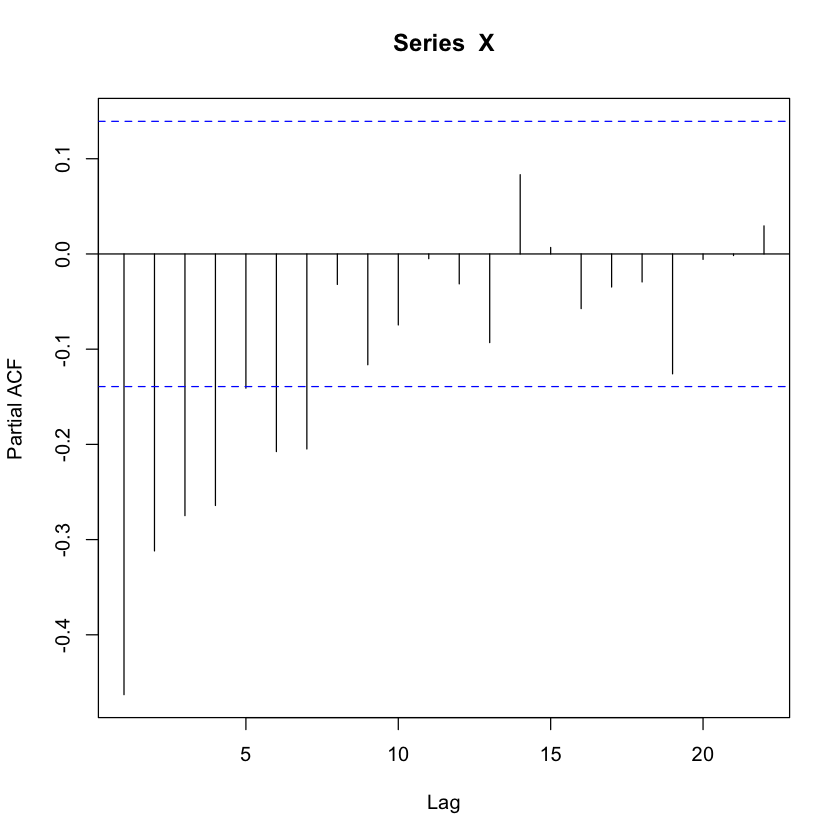

In [213]:
pacf = pacf(X)
pacf

In [27]:
double_process_df <- function(data){
    A <- data$X..A...
    B <- data$X..B...
    C <- data$X..C...
#     D <- data$X..D...
#     E <- data$X..E...
#     F <- data$X..F...
    AB <- data$X..A....B..
    ABC <- data$X..A....B....C..
#     DE <- data$X..D....E..
#     DEF <- data$X..D....E....F..
    A <- diff(A)
    B <- diff(B)
    C <- diff(C)
    A <- diff(A)
    B <- diff(B)
    C <- diff(C)
#     D <- diff(D)
#     E <- diff(E)
#     F <- diff(F)
    AB <- diff(AB)
    ABC <- diff(ABC)
    AB <- diff(AB)
    ABC <- diff(ABC)
#     DE <- diff(DE)
#     DEF <- diff(DEF)
    df <- data.frame(A,B,C,AB,ABC)
#     df <- data.frame(A,B,C,D,E,F,AB,ABC,DE,DEF)
    return(df)
}

[1] 198

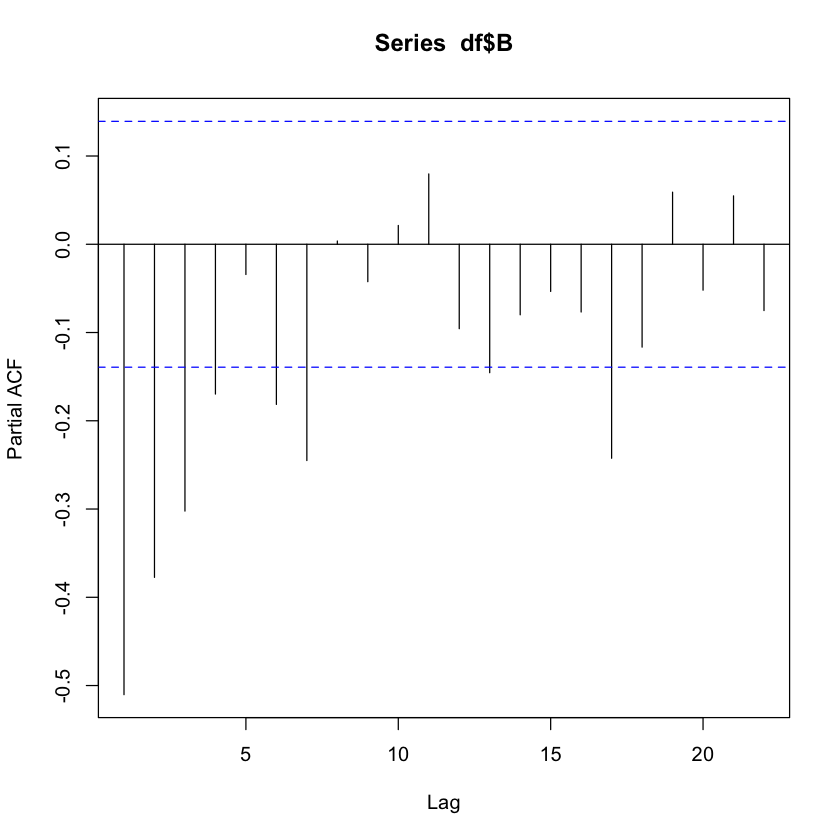

In [174]:

pacf <- pacf(df$B)
pacf$n.used

In [357]:
correct <- 0
AB_causes = c(2)
ABC_causes = c(7)
DE_causes = c(5)
DEF_causes = c(9)
num="001"
    path <- paste("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data",num,".csv",sep="")
    data <- read.csv(path)
    
    df <- process_df(data)

In [358]:
head(df)

,A,B,C,D,E,F,AB,ABC,DE,DEF
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,-1,0,0,1,-2,0,1,-4,-1,8
2,1,-1,0,-1,1,-2,6,3,5,0
3,1,-1,-2,-2,-1,2,1,3,0,6
4,0,1,1,0,0,1,4,9,-2,2
5,1,0,0,-2,1,1,-4,9,1,0
6,2,1,1,-2,-2,0,4,5,1,4


In [31]:
dff$gg <- diff(gg)

In [32]:
dff

haha,gg
<dbl>,<dbl>
1,1
1,1
1,1
1,1


In [224]:
data <- read.csv("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data001.csv")
#data <- read.csv("/Users/suhong/Downloads/simu_datawq.csv")

In [60]:
process_df <- function(data){
    A <- data$X..A...
    B <- data$X..B...
    C <- data$X..C...
    D <- data$X..D...
    E <- data$X..E...
    F <- data$X..F...
    AB <- data$X..A....B..
    ABC <- data$X..A....B....C..
    DE <- data$X..D....E..
    DEF <- data$X..D....E....F..
    A <- diff(A)
    B <- diff(B)
    C <- diff(C)
    D <- diff(D)
    E <- diff(E)
    F <- diff(F)
    AB <- diff(AB)
    ABC <- diff(ABC)
    DE <- diff(DE)
    DEF <- diff(DEF)
    df <- data.frame(A,B,C,D,E,F,AB,ABC,DE,DEF)
    return(df)
}

In [225]:
df <- process_df(data)

In [245]:
# grangertest(X,y,order = lag)
X <- df$B
Y <- df$A
lag <- select_time_lags(X)
print(lag)
grangertest(X,Y,order=2)

[1] 1


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,192,NA,NA,NA
2,194,-2,1.465842,0.2334555


[1] 3

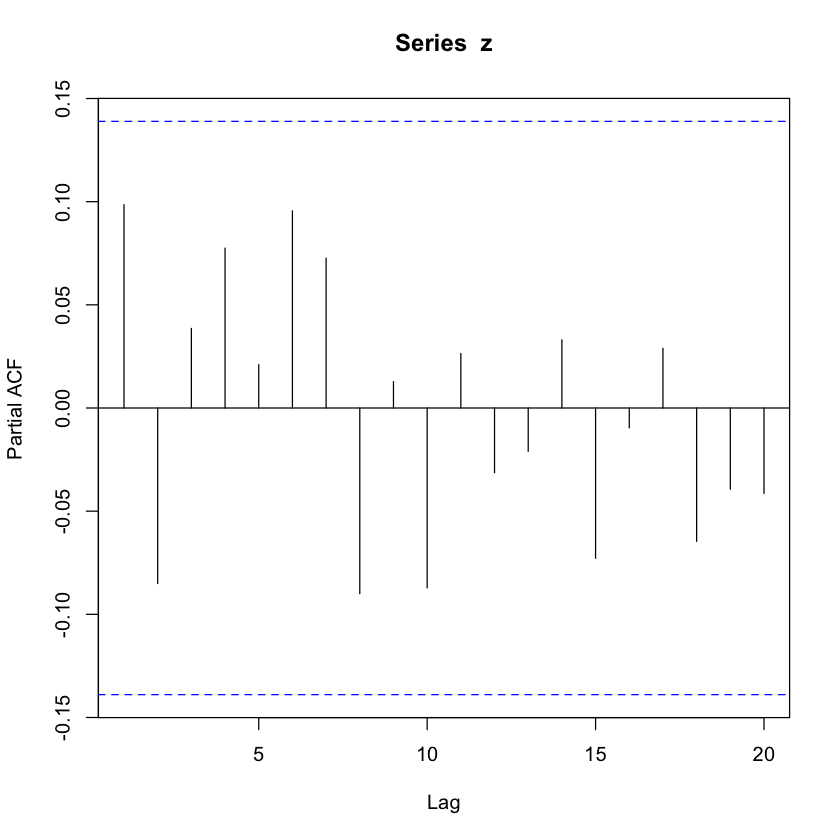

In [275]:
select_time_lags(X,thres=0.05)


Partial autocorrelations of series ‘df$B’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.492 -0.420 -0.280 -0.144 -0.129 -0.145 -0.032 -0.036 -0.120 -0.100 -0.154 
    12     13     14     15     16     17     18     19     20     21     22 
-0.100 -0.008 -0.071 -0.033 -0.016 -0.099 -0.066 -0.117 -0.015 -0.056 -0.013 

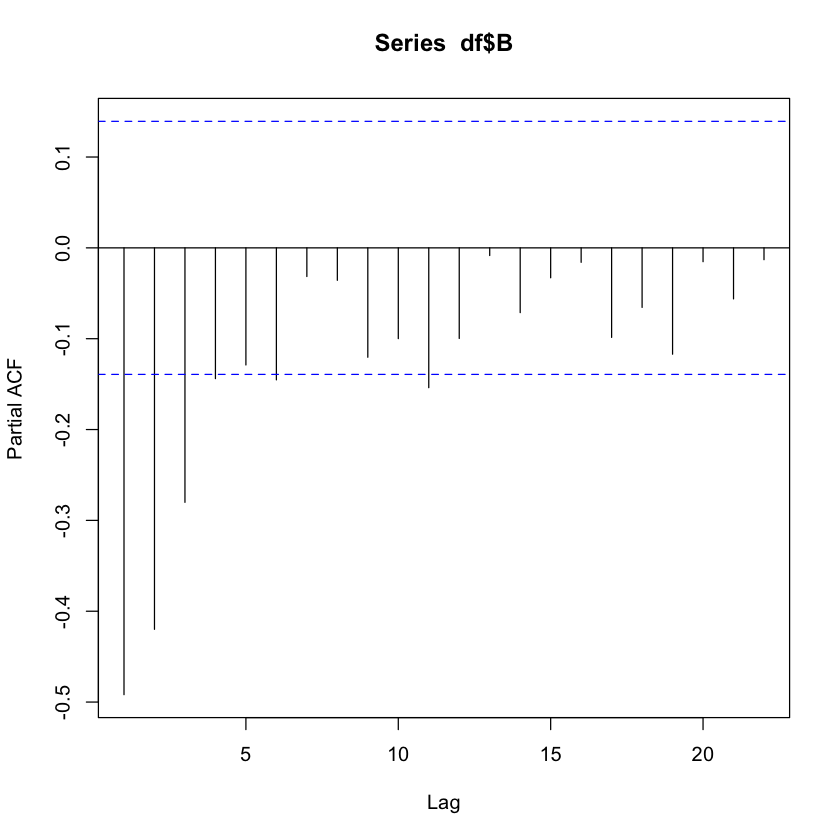

In [159]:
pacf <- pacf(df$B)
pacf

In [116]:
1.96/sqrt(198)

[1] 0.1392911

In [106]:
str(pacf)

List of 6
 $ acf   : num [1:22, 1, 1] -0.509 -0.227 -0.24 -0.146 -0.148 ...
 $ type  : chr "partial"
 $ n.used: int 198
 $ lag   : num [1:22, 1, 1] 1 2 3 4 5 6 7 8 9 10 ...
 $ series: chr "X"
 $ snames: NULL
 - attr(*, "class")= chr "acf"


In [329]:
grangertest(X,Y,order=lag)[2,4]

[1] 0.03378154

In [148]:
correct <- 0
AB_causes = c(2)
ABC_causes = c(4)
num="002"
    path <- paste("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data",num,".csv",sep="")
    data <- read.csv(path)
    
    df <- double_process_df(data)
    
    #testing causes of AB
    causes = c()
    for (index in 1:5){
        if (index==4) {next}
        X <- df[,index]
        Y <- df$AB
        lag <- select_time_lags(X)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes = append(causes,index)}}
    if(length(causes)!=0){
        cat("before filter",causes,sep=" ")
        print(" ")
        if(length(causes)>1){
            X=df[,causes]
            causes <-causes[filter_cause(X,Y,thres=0.3)]
        }
        cat("after filter", causes,sep=" ")
        print(" ")
    }
    print(causes) 
    if (reasonable_cause(causes,"AB")) {correct <- correct+1}
    
    # testing causes of ABC
    causes = c()
    for (index in 1:5){
        if (index==5) {next}
        X <- df[,index]
        Y <- df$ABC
        lag <- select_time_lags(X)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes = append(causes,index)
}
    }
    if(length(causes)!=0){
        cat("before filter",causes,sep=" ")
        if(length(causes)>1){
            X=df[,causes]
            causes <-causes[filter_cause(X,Y,thres=0.3)]
        }
        cat("after filter", causes,sep=" ")
        print(" ")
    }
    if (reasonable_cause(causes,type="ABC")) {correct <- correct+1}
    

NULL


In [149]:
correct

[1] 0

In [14]:
# grangertest(X,y,order = lag)
X <- data.frame(df$A,df$B,df$ABC)
Y <- df$AB
lag <- select_time_lags(X,thres=0.02)
print(lag)
filter_cause(X,Y)

[1] 5


[1] 1 3 2

In [153]:
#testing causes of AB
    causes = c()
    for (index in 1:5){
        if (index==4) {next}
        X <- df[,index]
        Y <- df$AB
        lag <- select_time_lags(X)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes = append(causes,index)}}
print(c())
#     if(length(causes)!=0){
#         cat("before filter",causes,sep=" ")
#         print(" ")
#         if(length(causes)>1){
#             X=df[,causes]
#             causes <-causes[filter_cause(X,Y,thres=0.3)]
#         }
#         cat("after filter", causes,sep=" ")
#         print(" ")
#     }
#     print(causes) 
#     if (reasonable_cause(causes,"AB")) {correct <- correct+1}
    

NULL



Partial autocorrelations of series ‘df$A’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.509 -0.227 -0.240 -0.146 -0.148 -0.095 -0.061 -0.192 -0.036 -0.136 -0.012 
    12     13     14     15     16     17     18     19     20     21     22 
 0.038 -0.066 -0.144 -0.017 -0.070  0.020 -0.035 -0.071 -0.105 -0.099 -0.109 

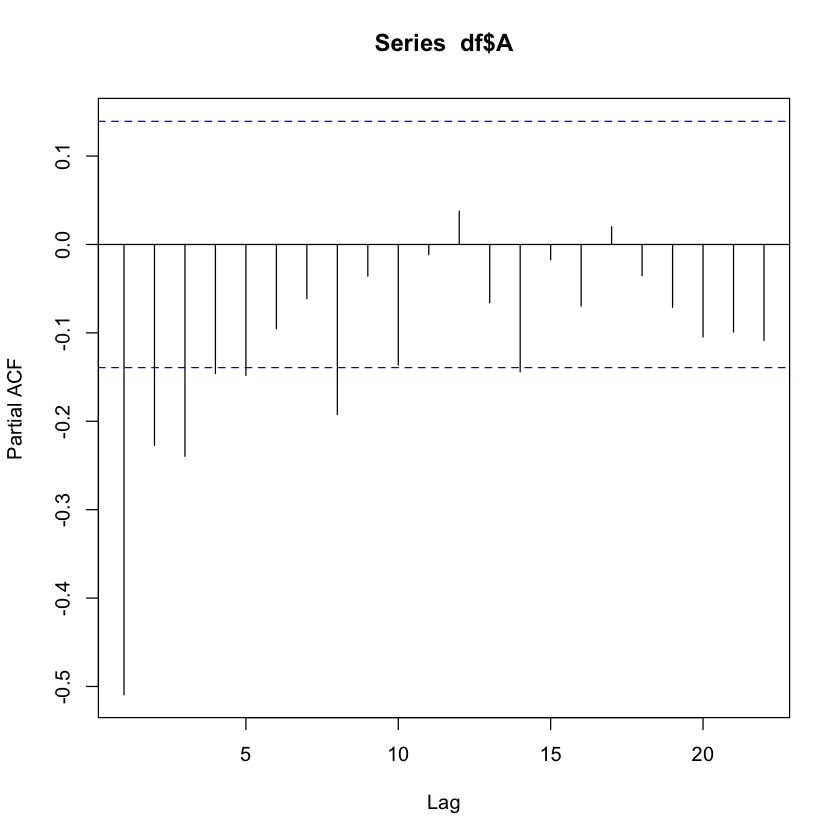

In [121]:
pacf <- pacf(df$A)
pacf

In [80]:
# testing causes of ABC
    causes = c()
    for (index in 1:5){
        print(index)
        if (index==5) {next}
        X <- df[,index]
        Y <- df$ABC
        lag <- select_time_lags(X,thres=0.1)
        p <- grangertest(X,Y,order=lag)[2,4]
        if (p<0.15){causes = append(causes,index)
}
    }
print(causes)
    if(length(causes)!=0){
        cat("before filter",causes,sep=" ")
        if(length(causes)>1){
            X=df[,causes]
            causes <-causes[filter_cause(X,Y,thres=0.3)]
        }
        cat("after filter", causes,sep=" ")
        print(" ")
    }
    if (reasonable_cause(causes,type="ABC")) {correct <- correct+1}
    

[1] 1


ERROR: Error in waldtest.lm(fm, 2, ...): there are aliased coefficients in the model


In [47]:
reasonable_cause <- function(causes,type){
    if (length(causes)==0){return(FALSE)}
    
    if(type == "AB"){
        if(all(causes %in% c(1,2))){return(TRUE)}
    }
    
    if(type=="ABC"){
        if(all(causes %in% c(1,2,3,4))){return(TRUE)}
    }
    return(FALSE)
}

In [71]:
p <- grangertest(df$AB,df$ABC,order=lag)[2,4]

ERROR: Error in waldtest.lm(fm, 2, ...): there are aliased coefficients in the model


In [73]:
cor(df$AB,df$ABC)

[1] 0.4177718

In [85]:
select_time_lags(df$A)

[1] 6

In [88]:
X <- df[,1]
        Y <- df$ABC
        lag <- select_time_lags(X,thres=0.1)
print(lag)
        p <- grangertest(X,Y,order=6)[2,4]
        if (p<0.15){causes = append(causes,index)
}

[1] -1


In [225]:
summary(lm(Y ~ lag(X, k=1:4)))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'summary': the condition has length > 1


In [227]:
Stock.Close <- c(102.12,102.62,100.12,103.00,103.87,103.12,105.12)
Close.Dates <- as.Date(c(10660,10661,10662,10665,10666,10667,10668),origin="1970-01-01")
Stock.Close <- zoo(Stock.Close,Close.Dates)

In [231]:
lag(Stock.Close，k=1:3)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:16: unexpected input
1: lag(Stock.Close，
                   ^


In [259]:
dd <- data(ChickEgg)
head(ChickEgg)

chicken,egg
468491,3581
449743,3532
436815,3327
444523,3255
433937,3156
389958,3081


In [238]:
if(require(dynlm)) {
  ## chickens granger-cause eggs?
  em <- dynlm(egg ~ L(egg, 1) + L(egg, 2) + L(egg, 3), data = ChickEgg)
  em2 <- update(em, . ~ . + L(chicken, 1) + L(chicken, 2) + L(chicken, 3))
  waldtest(em, em2)

  ## eggs granger-cause chickens?
  cm <- dynlm(chicken ~ L(chicken, 1) + L(chicken, 2) + L(chicken, 3), data = ChickEgg)
  cm2 <- update(cm, . ~ . + L(egg, 1) + L(egg, 2) + L(egg, 3))
  waldtest(cm, cm2)
}

,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,47,NA,NA,NA
2,44,3,5.404984,0.002966397


In [359]:
summary(dynlm(chicken ~ L(chicken, 1) + L(chicken, 2) + L(chicken, 3)+L(egg,1:3), data = ChickEgg))


Time series regression with "ts" data:
Start = 1933, End = 1983

Call:
dynlm(formula = chicken ~ L(chicken, 1) + L(chicken, 2) + L(chicken, 
    3) + L(egg, 1:3), data = ChickEgg)

Residuals:
   Min     1Q Median     3Q    Max 
-52855 -10789  -1601  10393  49500 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)    1.335e+05  4.107e+04   3.251  0.00221 **
L(chicken, 1)  2.920e-01  1.843e-01   1.585  0.12019   
L(chicken, 2)  4.453e-01  1.855e-01   2.400  0.02069 * 
L(chicken, 3)  4.069e-03  1.741e-01   0.023  0.98146   
L(egg, 1:3)1   7.657e+01  2.528e+01   3.029  0.00409 **
L(egg, 1:3)2  -4.708e+01  3.939e+01  -1.195  0.23838   
L(egg, 1:3)3  -3.593e+01  2.854e+01  -1.259  0.21463   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21880 on 44 degrees of freedom
Multiple R-squared:  0.8091,	Adjusted R-squared:  0.7831 
F-statistic: 31.08 on 6 and 44 DF,  p-value: 2.772e-14


In [249]:
fit <- summary(dynlm(chicken ~ L(chicken, 1) + L(chicken, 2) + L(chicken, 3), data = ChickEgg))
fit$adj.r.squared

[1] 0.7220977

In [287]:
i=1
d <- data.frame(X,Y)
summary(dynlm(X ~ L(Y, 1:i) ))
#head(d)


Time series regression with "ts" data:
Start = 2, End = 199

Call:
dynlm(formula = X ~ L(Y, 1:i))

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8208 -1.1590  0.0101  1.0947  5.0101 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.01010    0.13317  -0.076    0.940
L(Y, 1:i)   -0.08456    0.05681  -1.488    0.138

Residual standard error: 1.874 on 196 degrees of freedom
Multiple R-squared:  0.01118,	Adjusted R-squared:  0.006133 
F-statistic: 2.216 on 1 and 196 DF,  p-value: 0.1382


In [278]:
X <- ts(X)
Y <- ts(Y)

In [356]:
time_lag <- function(X,y){
    X <- ts(X)
    y <- ts(y)
    best_lag <- -1
    best_AIC <- 10e6
    for(i in 1:20){
        fit <- dynlm(X~L(X,1:i))
        aic <- BIC(fit)
        print(aic)
        if(aic<best_AIC){
            best_lag <- i
            best_AIC <- aic
        }
    }
    return (best_lag)
}

In [371]:
data <- read.csv("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data002.csv")
df <- double_process_df(data)
X <- df$A
Y <- df$AB
#time_lag(X,Y)

In [372]:
select_time_lags(X)

[1] 4

In [373]:
grangertest(X,Y,order=4)

,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,185,NA,NA,NA
2,189,-4,1.582689,0.1806703


In [326]:
X <- ts(X)
Y <- ts(Y)
i=10
sfit <- dynlm(Y~L(Y,1:i)+L(X,1:i))
summary(sfit)


Time series regression with "ts" data:
Start = 11, End = 198

Call:
dynlm(formula = Y ~ L(Y, 1:i) + L(X, 1:i))

Residuals:
    Min      1Q  Median      3Q     Max 
-20.258  -5.913  -0.147   5.081  21.882 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.03623    0.62922   0.058 0.954159    
L(Y, 1:i)1  -0.86447    0.07956 -10.865  < 2e-16 ***
L(Y, 1:i)2  -0.84553    0.10087  -8.382 2.06e-14 ***
L(Y, 1:i)3  -0.74017    0.11506  -6.433 1.27e-09 ***
L(Y, 1:i)4  -0.73031    0.12280  -5.947 1.55e-08 ***
L(Y, 1:i)5  -0.57475    0.12678  -4.533 1.10e-05 ***
L(Y, 1:i)6  -0.59876    0.12577  -4.761 4.16e-06 ***
L(Y, 1:i)7  -0.52587    0.12202  -4.310 2.78e-05 ***
L(Y, 1:i)8  -0.45836    0.11369  -4.032 8.40e-05 ***
L(Y, 1:i)9  -0.33559    0.09933  -3.379 0.000907 ***
L(Y, 1:i)10 -0.15951    0.07690  -2.074 0.039594 *  
L(X, 1:i)1   0.51689    0.24513   2.109 0.036465 *  
L(X, 1:i)2   0.17583    0.30199   0.582 0.561195    
L(X, 1:i)3   0.22397    0.32118   0.6

In [323]:
names(summary(dynlm(Y~L(Y,1:i)+L(X,1:i))))

[1] "call"          "terms"         "residuals"     "coefficients" 
 [5] "aliased"       "sigma"         "df"            "r.squared"    
 [9] "adj.r.squared" "fstatistic"    "cov.unscaled"  "frequency"

In [324]:
summary(dynlm(Y~L(Y,1:i)+L(X,1:i)))$residuals

A Time Series:
          11           12           13           14           15           16 
 10.08385518  -6.16183380  -6.38511541   2.77838108  13.96259073  -2.52448206 
          17           18           19           20           21           22 
 -8.57637316  13.80362181  -4.89526381   2.23648765  -5.00322821   4.12791818 
          23           24           25           26           27           28 
 -5.94534300   2.79307534 -11.73914842   0.94262556  -0.13371847  -1.84503874 
          29           30           31           32           33           34 
  1.42892687 -12.31906230  -6.65804992   9.01342106   1.36778155   6.82788127 
          35           36           37           38           39           40 
  2.22539389  -1.53297884   1.75196703  -1.01157784  -4.81931136  10.57969251 
          41           42           43           44           45           46 
 -3.28874450  12.32808424 -10.85481252   9.96327027  -6.99329986  20.93098674 
          47           48           49           50           51           52 
 -1.11506913 -11.01108878 -12.58186181  -3.90600358  -9.71287353  -5.52037308 
          53           54           55           56           57           58 
-13.07005592  11.00992836  -0.08976652   4.49322280  20.97246995  -2.75020699 
          59           60           61           62           63           64 
  2.43237600  14.59974311  -1.19551769  -2.89171974  -5.15774704   2.71962452 
          65           66           67           68           69           70 
 -8.66371762   0.71911600  -6.08736850  -6.02462775   7.53168628   5.44976572 
          71           72           73           74           75           76 
 -5.90247375   2.79854610  -0.16018812  -1.86396007   9.14613143  -9.29412795 
          77           78           79           80           81           82 
 -3.11962955   2.30376666   2.21587148   0.37705581  -8.98912809  -0.18961544 
          83           84           85           86           87           88 
-17.52085751   3.74505647  21.88239374   2.32062430  -7.92888510   4.61378320 
          89           90           91           92           93           94 
  1.12020678  -3.89737497   4.36186552   1.10247738  -0.30227975  -7.28081442 
          95           96           97           98           99          100 
-10.17569397  10.71442044  -6.23409795  -3.04592423   8.25605219   4.91417879 
         101          102          103          104          105          106 
  8.53730508  10.83420511   4.91034209   0.15295321  -4.13366897   1.17301011 
         107          108          109          110          111          112 
-19.83327641  -7.70600990  -6.17203180  -5.19682834  -4.65024494  11.78952902 
         113          114          115          116          117          118 
 16.69926106  -2.78064559   7.92741844  -2.53716040  -1.17126120 -11.32881697 
         119          120          121          122          123          124 
  9.72996394   0.61828128  -7.62923960 -14.67487377   0.89207324  -4.14589354 
         125          126          127          128          129          130 
 10.80168211   9.19757645  -9.06046299  18.32890376  -9.31826681 -12.16985612 
         131          132          133          134          135          136 
  0.28008284   1.55733623  -0.43506906  -7.74345854  -0.49125350   8.83174038 
         137          138          139          140          141          142 
 -6.44921347   0.82287692 -10.45876165   1.85819372  10.18485749   6.31454410 
         143          144          145          146          147          148 
 10.89560743   6.68799673   7.50548765  -4.35254906 -13.18045645   9.15292230 
         149          150          151          152          153          154 
 -1.23395721   4.95793042 -18.46721063  -7.44119328   2.01544804  13.79218787 
         155          156          157          158          159          160 
 -6.51116453  -3.23471087  -1.43578014  -7.33756613   5.69875971   8.82048453 
         161          162          

In [330]:
aictab(sfit)

ERROR: Error in formatCands(cand.set): 
Functions do not support mixture of model classes



In [340]:
BIC(sfit)

[1] 1436.535

In [407]:
data <- read.csv("/Users/suhong/Desktop/UROP_Data/UROP/Synthetic/data/simu_data001.csv")
df <- double_process_df(data)
#write.csv(df,"/Users/suhong/Desktop/UROP_Data/inter_data/test1.csv")

In [408]:
head(df)

,A,B,C,AB,ABC
,<int>,<int>,<int>,<int>,<int>
1,0,3,3,4,12
2,-1,-2,-1,-27,-13
3,-2,1,3,16,-15
4,7,0,-4,0,3
5,-1,1,2,-2,1
6,0,1,-2,6,6


In [414]:
X <- df$A
Y <- df$ABC
length(X)

[1] 198

In [401]:
X_lag <- select_time_lags(X)
Y_lag <- select_time_lags(Y)
print(X_lag)
print(Y_lag)
diff = X_lag-Y_lag
delete <- max(X_lag,Y_lag)
X <- X[-Y_lag]
Y <- Y[-X_lag]
X <- ts(X)
Y <- ts(Y)
em <- dynlm(Y ~ L(Y,1:Y_lag))
em2 <- update(em, . ~ . + L(X, 1:X_lag) )
waldtest(em, em2)

[1] 8
[1] 7


ERROR: Error in waldtest.default(object, ..., test = match.arg(test)): models were not all fitted to the same size of dataset


In [395]:
X_lag <- select_time_lags(X)
Y_lag <- select_time_lags(Y)
print(X_lag)
print(Y_lag)
diff = X_lag-Y_lag
delete <- max(X_lag,Y_lag)
X <- X[-Y_lag]
Y <- Y[-X_lag]

[1] 7
[1] 7


In [394]:
length(X)

function (x)  .Primitive("length")

In [419]:
self_granger <- function(X,y){
    best_p <- 1
    for (i in 1:20){
        p <- grangertest(X,y,order=i)[2,4]
        if(p<best_p){
            best_p <- p
        }
    }
    # print(p)
    if(best_p<0.1){
        return (TRUE)
    }
    else{return(FALSE)}
}

In [415]:
self_granger(X,Y)

[1] 0.002274522


[1] TRUE